# CV Recognition with Concrete ML

## Setup and Data Preparation

In [6]:
import os
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time

from sklearn.ensemble import RandomForestClassifier as SkRandomForestClassifier
from sklearn.linear_model import LogisticRegression as SkLogisticRegression
from sklearn.svm import LinearSVC as SkLinearSVC
from sklearn.neighbors import KNeighborsClassifier as SkKNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier as SkDecisionTreeClassifier
from xgboost import XGBClassifier as SkXGBClassifier

from concrete.ml.sklearn.rf import RandomForestClassifier
from concrete.ml.sklearn.linear_model import LogisticRegression
from concrete.ml.sklearn.svm import LinearSVC
from concrete.ml.sklearn.neighbors import KNeighborsClassifier
from concrete.ml.sklearn.tree import DecisionTreeClassifier
from concrete.ml.sklearn.xgb import XGBClassifier

In [7]:
# Data loading and preprocessing
folder_path = 'dataset/ResumesJsonAnnotated/ResumesJsonAnnotated'
data = []
dataskill = []

for file_name in os.listdir(folder_path):
    if file_name.endswith('.json'):
        with open(os.path.join(folder_path, file_name), 'r', encoding='utf-8') as file:
            json_data = json.load(file)
            text = json_data['text']
            annotations = json_data.get('annotations', [])
            skills = []
            for annotation in annotations:
                start, end, label = annotation
                skill = label.replace('SKILL: ', '').lower()
                skills.append(skill)
                dataskill.append({
                    'file_name': file_name,
                    'text': text,
                    'Skill': skill
                })
            data.append({
                'file_name': file_name,
                'text': text,
                'Skills': skills
            })

df = pd.DataFrame(data)
dfskill = pd.DataFrame(dataskill)

In [9]:
# Filtering for JavaScript skills
df['prediction'] = 0
df_filtered = dfskill[dfskill['Skill'].str.contains(r'(js|javascript|java script)', case=False, na=False)]
df_filtered = df[df['file_name'].isin(df_filtered['file_name'])]
df['prediction'] = df['file_name'].isin(df_filtered['file_name']).astype(int)

# Balancing the dataset
one = df[df['prediction'] == 1]
zero = df[df['prediction'] == 0].sample(n=len(one), random_state=42)
dfModel = pd.concat([one, zero])
dfModel = dfModel.sample(frac=1, random_state=42).reset_index(drop=True)

# Preparing the final dataset
dfModel = dfskill[dfskill['file_name'].isin(dfModel['file_name'])]
dfModel = dfModel.merge(df[['file_name', 'prediction']], on='file_name', how='left')
dfModel = dfModel.drop(columns=['text'])

df_pivot = dfModel.pivot_table(index='file_name', columns='Skill', aggfunc='size', fill_value=0).astype(bool)
df_prediction = dfModel[['file_name', 'prediction']].drop_duplicates().set_index('file_name')
dfModel = df_pivot.join(df_prediction, lsuffix='_skill', rsuffix='_pred').reset_index()

# Preparing features and target
dfModel = dfModel.drop('file_name', axis=1)
X = dfModel.drop('prediction_pred', axis=1)
y = dfModel['prediction_pred']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Data normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

## Model Training and Evaluation

In [10]:
# Models to compare
models = {
    "Random Forest": (SkRandomForestClassifier(n_estimators=100, random_state=42), RandomForestClassifier(n_estimators=100, random_state=42)),
    "Logistic Regression": (SkLogisticRegression(max_iter=1000, random_state=42), LogisticRegression(max_iter=1000, random_state=42)),
    "K-Nearest Neighbors": (SkKNeighborsClassifier(), KNeighborsClassifier()),
    "Decision Tree": (SkDecisionTreeClassifier(random_state=42), DecisionTreeClassifier(random_state=42)),
    "Linear SVC": (SkLinearSVC(random_state=42, max_iter=10000), LinearSVC(random_state=42, max_iter=10000)),
    "XGBoost Classifier": (SkXGBClassifier(random_state=42, use_label_encoder=False), XGBClassifier(random_state=42, use_label_encoder=False))
}

results = []

# Training and Validation
for model_name, (sk_model, fhe_model) in models.items():
    # Sklearn model
    start_time = time.time()
    sk_model.fit(X_train, y_train)
    sk_training_time = time.time() - start_time
    sk_y_pred = sk_model.predict(X_val)
    sk_accuracy = accuracy_score(y_val, sk_y_pred)
    
    # FHE model
    start_time = time.time()
    fhe_model.fit(X_train, y_train)
    fhe_training_time = time.time() - start_time
    fhe_y_pred = fhe_model.predict(X_val)
    fhe_accuracy = accuracy_score(y_val, fhe_y_pred)
    
    # Calculate ratios
    time_ratio = fhe_training_time / sk_training_time
    accuracy_ratio = fhe_accuracy / sk_accuracy
    
    results.append({
        "Model": model_name,
        "Sklearn Accuracy": sk_accuracy,
        "Sklearn Time": sk_training_time,
        "FHE Accuracy": fhe_accuracy,
        "FHE Time": fhe_training_time,
        "Time Ratio (FHE/Sklearn)": time_ratio,
        "Accuracy Ratio (FHE/Sklearn)": accuracy_ratio
    })

results_df = pd.DataFrame(results)
results_df

,Model,Sklearn Accuracy,Sklearn Time,FHE Accuracy,FHE Time,Time Ratio (FHE/Sklearn),Accuracy Ratio (FHE/Sklearn)
0,Random Forest,0.941176,1.100896,0.960784,30.823254,27.998337,1.020833
1,Logistic Regression,0.960784,0.289435,0.960784,0.569372,1.967185,1.000000
2,K-Nearest Neighbors,0.549020,0.010897,0.568627,1.315699,120.740422,1.035714
3,Decision Tree,0.901961,0.074590,0.901961,31.805800,426.408553,1.000000
4,Linear SVC,0.960784,16.789982,0.960784,15.506661,0.923566,1.000000
5,XGBoost Classifier,0.941176,7.475504,0.941176,17.769382,2.377015,1.000000


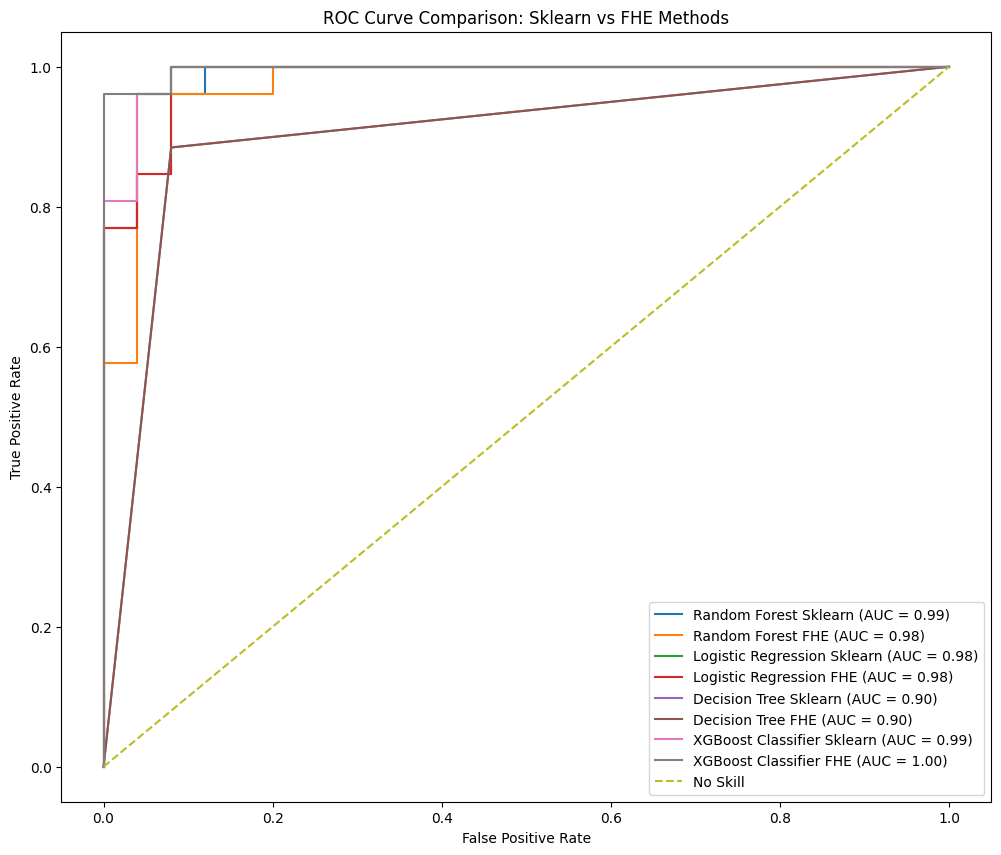

In [11]:
plt.figure(figsize=(12, 10))

for model_name, (sk_model, fhe_model) in models.items():
    if hasattr(sk_model, "predict_proba") and model_name != "K-Nearest Neighbors":
        sk_y_pred_proba = sk_model.predict_proba(X_val)[:, 1]
        fhe_y_pred_proba = fhe_model.predict_proba(X_val)[:, 1]
        
        sk_fpr, sk_tpr, _ = roc_curve(y_val, sk_y_pred_proba)
        fhe_fpr, fhe_tpr, _ = roc_curve(y_val, fhe_y_pred_proba)
        
        sk_roc_auc = auc(sk_fpr, sk_tpr)
        fhe_roc_auc = auc(fhe_fpr, fhe_tpr)
        
        plt.plot(sk_fpr, sk_tpr, label=f'{model_name} Sklearn (AUC = {sk_roc_auc:.2f})')
        plt.plot(fhe_fpr, fhe_tpr, label=f'{model_name} FHE (AUC = {fhe_roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: Sklearn vs FHE Methods')
plt.legend(loc="lower right")
plt.show()